In [23]:
# -----------------------------------------
# Imports
# -----------------------------------------
import numpy as np
import pickle
import time as tm
import xarray as xr
import os
import matplotlib.pyplot as plt
import random

# Lorenz 96 integrator
import l96adaptive as l96t

# Ginelli Imports
import ginelli_utilities as utilities
from ginelli_observers import *
from ginelli_plot import *

In [24]:
# -----------------------------------------
# Setup & Parameter Choices
# -----------------------------------------

In [28]:
dump_size = 50 # How many observations before output

# Time Parameter Choices
tau = 0.1 # tau & transient feed in to the integrator
transient = 10
ka = 50 # BLV convergence
kb = 100 # Number of observations
kc = 50 # CLV convergence

# Integrator
K = 5
J =5
runner = l96t.Integrator(K=K, J=J)
tangent_runner = l96t.TangentIntegrator(K=K, J=J)
ginelli_runner = utilities.Forward(tangent_runner, tau)

# Observables
Rlooker = RMatrixObserver(ginelli_runner)
BLVlooker = BLVMatrixObserver(ginelli_runner)
TrajectoryLooker = TrajectoryObserver(ginelli_runner)

# Timing the algorithm
timings = {}
start = tm.time()

# Making Output Storage
utilities.make_cupboard()

Made directory ginelli.

Made directory ginelli/trajectory.

Made directory ginelli/step2.

Made directory ginelli/step2/R.

Made directory ginelli/step2/BLV.

Made directory ginelli/step3.

Made directory ginelli/step4.

Made directory ginelli/step5.



In [2]:
import numpy as np
print()

[0.0625   0.296875 0.53125  0.765625 1.      ]


In [29]:
# -----------------------------------------
# Forward Part of Ginelli Algorithm
# -----------------------------------------

# -----------------------------------------
# Transient and Step 1, BLV Convergence
# -----------------------------------------

print('\nTransient beginning.\n')
runner.integrate(transient) # runner does the transient integration, then we update tangent_runner state
tangent_runner.set_state(runner.state, tangent_runner.tangent_state)
print('\nTransient finished. Beginning BLV convergence steps.\n')

timings.update({'transient': tm.time() - start})

# BLV Convergence steps

ginelli_runner.run(ka, noprog=False)

timings.update({'Step1': tm.time() - timings['transient'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Step 2, BLV Observation.
# -----------------------------------------

print('\nBLV convergence finished. Beginning to observe BLVs.\n')
blocks = int(kb/dump_size) # How many times we dump
remainder = kb%dump_size # Rest of observations

for i in tqdm(range(blocks)):

    utilities.make_observations(ginelli_runner, [Rlooker, BLVlooker, TrajectoryLooker], dump_size, 1, noprog=False)
    # Observation frequency has to be 1 if we're reversing CLVs
    Rlooker.dump('ginelli/step2/R')
    BLVlooker.dump('ginelli/step2/BLV')
    TrajectoryLooker.dump('ginelli/trajectory')

utilities.make_observations(ginelli_runner, [Rlooker, BLVlooker], remainder, 1, noprog=False)
Rlooker.dump('ginelli/step2/R')
BLVlooker.dump('ginelli/step2/BLV')
TrajectoryLooker.dump('ginelli/trajectory')

timings.update({'Step2': tm.time() - timings['Step1'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Step 3, CLV Convergence Step, Forward
# -----------------------------------------

print('\nBLV observations finished. CLV convergence beginning. Just observing Rs.\n')
blocks = int(kc/dump_size)
remainder = kc%dump_size

for i in range(blocks):

    utilities.make_observations(ginelli_runner, [Rlooker], dump_size, 1, noprog=False)
    Rlooker.dump('ginelli/step3')

utilities.make_observations(ginelli_runner, [Rlooker], remainder, 1, noprog=False)
Rlooker.dump('ginelli/step3')

print('\nForward part all done :)')

timings.update({'Step3': tm.time() - timings['Step2'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Backward Part of Ginelli Algorithm
# -----------------------------------------

# -----------------------------------------
# Step 4, Reversing CLV Convergence Steps
# -----------------------------------------

R_files = os.listdir('ginelli/step3')
R_files.sort(reverse=True) # Ensuring files are in the right order

A = np.identity(ginelli_runner.size)

for file in R_files:
    R_history = xr.open_dataset('ginelli/step3/' + file)
    A = utilities.block_squish_norm(R_history, A) # This A is one timestep ahead of the R that pushed it
    R_history.close()
    print(f'Pushed A through {file}. Overwriting A.npy.\n')
    np.save('ginelli/step4/A.npy', A)

timings.update({'Step4': tm.time() - timings['Step3'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

# -----------------------------------------
# Step 5, Observing LVs and LEs
# -----------------------------------------

# Sorting files we will be working with

R_files = os.listdir('ginelli/step2/R')
R_files.sort(reverse=True)

BLV_files = os.listdir('ginelli/step2/BLV')
BLV_files.sort(reverse=True)

# Setting up observable storage

parameters = ginelli_runner.parameter_dict.copy()
parameters.update({'transient':transient,'ka':ka, 'kb':kb, 'kc':kc})
LyapunovLooker = LyapunovObserver(parameters, utilities.max_digit(BLV_files))

for [rfile, bfile] in zip(R_files, BLV_files): # Loop over files that were dumped
    R_history = xr.open_dataset('ginelli/step2/R/' + rfile)
    BLV_history = xr.open_dataset('ginelli/step2/BLV/' + bfile)

    Rs, BLVs = np.flip(R_history.R, axis = 0), np.flip(BLV_history.BLV, axis = 0) # Times series reversed

    for R, BLV in zip(Rs, BLVs):

        # CLV Calculation
        CLV = np.matmul(BLV.values, A)

        # FTCLE Calculation
        squishedA = np.linalg.solve(R, A)
        norms = np.linalg.norm(squishedA, axis=0, ord=2)
        ftcle = - np.log(norms)/(tau)
        A = squishedA/norms

        # FTBLE Calculation
        ftble = np.log(np.diag(R))/(tau)

        # Making observation
        time = R.time.item()
        LyapunovLooker.look(time, CLV, BLV.values, ftcle, ftble)


    LyapunovLooker.dump('ginelli/step5')
    R_history.close()
    BLV_history.close()

timings.update({'Step5': tm.time() - timings['Step4'] - start})
pickle.dump(timings, open("ginelli/timings.p", "wb" ))

print('Ginelli Algorithm finished.')



Transient beginning.


Transient finished. Beginning BLV convergence steps.





BLV convergence finished. Beginning to observe BLVs.




Observations written to ginelli/step2/R/R1.nc. Erasing personal log.

Observations written to ginelli/step2/BLV/BLV1.nc. Erasing personal log.

Observations written to ginelli/trajectory/Trajectory1.nc. Erasing personal log.




Observations written to ginelli/step2/R/R2.nc. Erasing personal log.

Observations written to ginelli/step2/BLV/BLV2.nc. Erasing personal log.

Observations written to ginelli/trajectory/Trajectory2.nc. Erasing personal log.





I have no observations! :(
I have no observations! :(
I have no observations! :(

BLV observations finished. CLV convergence beginning. Just observing Rs.




Observations written to ginelli/step3/R3.nc. Erasing personal log.




I have no observations! :(

Forward part all done :)
Pushed A through R3.nc. Overwriting A.npy.

Observations written to ginelli/step5/LyapObs2.nc. Erasing personal log.

Observations written to ginelli/step5/LyapObs1.nc. Erasing personal log.

Ginelli Algorithm finished.


In [30]:
ds.close()
ds = xr.open_mfdataset(f'ginelli/step5/*.nc', parallel=True, combine='by_coords', concat_dim='time')

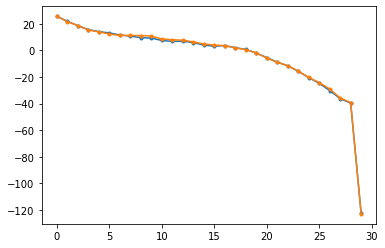

In [31]:
plt.plot(spectra(ds), '.-')
plt.plot(spectra(ds, geometry='B' ), '.-')

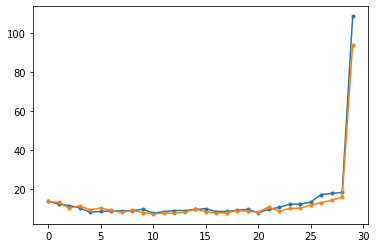

In [32]:
plt.plot(np.std(ds.ftble, axis=0), '.-')
plt.plot(np.std(ds.ftcle, axis=0), '.-')

In [ ]:
plt.plot(ds.ftble.sel(le_index=10))
plt.plot(ds.ftcle.sel(le_index=10))